In [27]:
import tensorflow as tf
import cv2
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [28]:
# Check TensorFlow version and devices
print("TensorFlow version:", tf.__version__)
print("Available devices:", tf.config.list_physical_devices())

# Test OpenCV installation
print("OpenCV version:", cv2.__version__)

TensorFlow version: 2.18.0
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
OpenCV version: 4.10.0


In [29]:
# Read the jaffed file data
unprocessed_jaffed_df = pd.read_csv("jaffed_data.txt", delim_whitespace=True, header=0)

#Find the column with the highest valued emotion in each row
processed_jaffed_df = unprocessed_jaffed_df.drop(columns=['PIC', '#'])
max_columns = processed_jaffed_df.idxmax(axis=1)

# Store the results in a new dataframe and pair with proper file name
jaffed_df = pd.DataFrame({
    'emotion': max_columns,
    'pixels': [f'jaffedbase/{unprocessed_jaffed_df.loc[index, "#"]}.tiff' for index in range(len(unprocessed_jaffed_df))]
})

C:\Users\wowen\AppData\Local\Temp\ipykernel_48912\945279305.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  unprocessed_jaffed_df = pd.read_csv("jaffed_data.txt", delim_whitespace=True, header=0)


In [30]:
# Function to read a .tiff image using tifffile and convert to space-separated pixel values
def image_to_pixel_string(image_path):
    # Read the .tiff image using tifffile, turn to 1D flattened array
    img_array = tifffile.imread(image_path)
    flattened = img_array.flatten()

    # Convert the flattened array to a space-separated string of pixel values
    # Done to match format of the CKextended dataset
    pixel_str = ' '.join(map(str, flattened))

    return pixel_str

In [31]:
# Populate the 'image' field with space-separated pixel values

# Iterate over the image column and insert pixel values as space-separated strings
for index, row in jaffed_df.iterrows():
    pixel_string = image_to_pixel_string(row['pixels'])
    if pixel_string:
        jaffed_df.at[index, 'pixels'] = pixel_string


# Display the new dataframe
print(jaffed_df)

    emotion                                             pixels
0       HAP  155 156 160 158 158 156 156 158 149 161 154 15...
1       HAP  163 168 169 171 165 167 162 155 166 165 165 17...
2       HAP  163 155 166 168 158 160 169 168 168 166 159 16...
3       HAP  156 158 159 153 153 152 158 158 153 154 157 15...
4       HAP  166 157 165 162 174 165 173 167 167 164 164 17...
..      ...                                                ...
208     DIS  59 56 57 55 50 54 55 58 61 61 64 59 61 65 75 7...
209     ANG  53 63 63 55 51 55 54 54 59 53 63 60 58 65 67 6...
210     SUR  36 32 35 42 40 36 45 45 45 46 46 44 46 45 48 4...
211     FEA  30 31 34 28 38 40 40 47 40 42 53 56 61 61 64 5...
212     FEA  42 42 38 45 41 42 46 40 31 38 40 42 45 37 45 4...

[213 rows x 2 columns]


In [32]:
# Find the Unique values in the emotion column
unique_emotions = jaffed_df['emotion'].unique()
print("Unique emotions in the dataset:", unique_emotions)

Unique emotions in the dataset: ['HAP' 'SAD' 'SUR' 'ANG' 'DIS' 'FEA']


In [33]:
# Map values to represent the same format as the CK+ dataset
# 0 : Anger
# 1 : Disgust
# 2 : Fear
# 3 : Happiness
# 4 : Sadness
# 5 : Surprise
# 6 : Neutral
# 7 : Contempt
emotion_mapping = {
    "ANG": 0,
    "DIS": 1,
    "FEA": 2,
    "HAP": 3,
    "SAD": 4,
    "SUR": 5
}
jaffed_df['emotion'] = jaffed_df['emotion'].map(emotion_mapping)
print(jaffed_df)
#Contains 256x256 flattened pixel array

     emotion                                             pixels
0          3  155 156 160 158 158 156 156 158 149 161 154 15...
1          3  163 168 169 171 165 167 162 155 166 165 165 17...
2          3  163 155 166 168 158 160 169 168 168 166 159 16...
3          3  156 158 159 153 153 152 158 158 153 154 157 15...
4          3  166 157 165 162 174 165 173 167 167 164 164 17...
..       ...                                                ...
208        1  59 56 57 55 50 54 55 58 61 61 64 59 61 65 75 7...
209        0  53 63 63 55 51 55 54 54 59 53 63 60 58 65 67 6...
210        5  36 32 35 42 40 36 45 45 45 46 46 44 46 45 48 4...
211        2  30 31 34 28 38 40 40 47 40 42 53 56 61 61 64 5...
212        2  42 42 38 45 41 42 46 40 31 38 40 42 45 37 45 4...

[213 rows x 2 columns]


In [34]:
#Load the CK+ Extended Dataset
CK_df = pd.read_csv("ckextended.csv", header=0)
CK_df = CK_df.drop(columns=['Usage'])
print(CK_df)
#Contains 48x48 flattened pixel array

     emotion                                             pixels
0          6  36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...
1          6  88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...
2          6  9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...
3          6  104 106 108 104 95 50 60 61 58 83 126 133 139 ...
4          6  68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...
..       ...                                                ...
915        5  87 86 88 92 92 127 231 248 251 253 254 254 254...
916        5  21 24 26 28 27 28 30 8 0 0 0 0 0 0 1 4 37 42 4...
917        5  76 40 31 38 28 34 38 36 41 36 46 38 44 26 45 5...
918        5  114 87 16 29 17 25 30 34 37 35 45 93 63 80 73 ...
919        5  101 102 99 96 98 42 23 18 15 17 27 34 17 24 29...

[920 rows x 2 columns]


In [35]:
#function that takes a space seperated flattened image and converts to a new size
def resize_flattened_image(flat_array:str, original_size:tuple, target_size:tuple):
    # convert to array
    flat_array = np.fromstring(flat_array, sep=" ", dtype=np.uint8)
    #resize
    reshaped_image = flat_array.reshape(original_size)
    resized_image = cv2.resize(reshaped_image, target_size, interpolation=cv2.INTER_LINEAR)
    resized_flattened = resized_image.flatten().astype(np.uint8)
    #convert back to str
    resized_string = " ".join(map(str, resized_flattened))
    
    return resized_string

In [36]:
CK_df['pixels'] = CK_df['pixels'].apply(lambda x: resize_flattened_image(x, (48,48), (256,256)))
print(CK_df)

     emotion                                             pixels
0          6  36 36 36 36 37 38 38 38 38 38 37 36 35 35 33 3...
1          6  88 88 88 86 83 80 78 75 69 59 48 38 27 19 16 1...
2          6  9 9 9 8 6 5 4 3 2 3 3 3 3 4 5 5 6 6 7 6 5 4 3 ...
3          6  104 104 104 104 105 105 105 106 106 107 107 10...
4          6  68 68 68 68 69 70 71 72 71 70 70 69 68 67 67 6...
..       ...                                                ...
915        5  87 87 87 87 86 86 86 86 86 86 87 87 88 88 89 8...
916        5  21 21 21 21 22 22 23 24 24 24 25 25 26 26 26 2...
917        5  76 76 76 70 64 57 50 43 39 37 36 34 32 31 32 3...
918        5  114 114 114 110 105 99 94 89 80 67 54 40 27 16...
919        5  101 101 101 101 101 101 102 102 102 101 100 10...

[920 rows x 2 columns]


In [37]:
data = pd.concat([jaffed_df, CK_df], ignore_index= True)
class_distribution = data['emotion'].value_counts()


print(class_distribution)

emotion
6    593
5    124
3    123
1    100
0     75
4     67
2     33
7     18
Name: count, dtype: int64


In [38]:
from sklearn.utils import resample
data_no7 = data[data['emotion'] != 7]

# data_majority = data_no7[data_no7['emotion'] == 6]
# data_minority = data_no7[data_no7['emotion'] != 6]

# data_majority_downsampled = resample(data_majority, 
#             replace=False,  # No replacement
#             n_samples=100,  # Downsample to 150
#             random_state=70)

# data_minority_samples = []
# for emotion_class in data_minority['emotion'].unique():
#     class_data = data_minority[data_minority['emotion'] == emotion_class]
    
#     # Only upsample if the class size is less than the target
#     if len(class_data) < 100:
#         upsampled_class = resample(class_data,
#                                    replace=True,  # Sample with replacement
#                                    n_samples=100,  # Target size for each class
#                                    random_state=70)
#         data_minority_samples.append(upsampled_class)
#     else:
#         data_minority_samples.append(class_data)
data_sampled = []
for emotion_class in data_no7['emotion'].unique():
    class_data = data_no7[data_no7['emotion'] == emotion_class]
    
    # Only upsample if the class size is less than the target
    class_sampled = resample(class_data,
                                replace=True,  # Sample with replacement
                                n_samples=100,  # Target size for each class
                                random_state=0)
    data_sampled.append(class_sampled)
data_processed = pd.concat([*data_sampled])

# data_processed = pd.concat([data_majority_downsampled, *data_minority_samples])

print("Class distribution after oversampling:")
print(data_processed['emotion'].value_counts())

Class distribution after oversampling:
emotion
3    100
4    100
5    100
0    100
1    100
2    100
6    100
Name: count, dtype: int64


In [39]:
X = data_processed['pixels'].values
y = data_processed['emotion'].values
#CK_df = CK_df[CK_df['emotion'] != 7]
#X_train, X_test, y_train, y_test = train_test_split(CK_df['pixels'].values, CK_df['emotion'].values, test_size=.2, random_state=64)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=48)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

print("Training counts:")
unique_elements, counts = np.unique(y_train, return_counts=True)
for element, count in zip(unique_elements, counts):
    print(f"Element {element} occurs {count} times")
    
print("Testing counts:")
unique_elements, counts = np.unique(y_test, return_counts=True)
for element, count in zip(unique_elements, counts):
    print(f"Element {element} occurs {count} times")

(560,) (140,) (560,) (140,)
Training counts:
Element 0 occurs 81 times
Element 1 occurs 83 times
Element 2 occurs 77 times
Element 3 occurs 78 times
Element 4 occurs 78 times
Element 5 occurs 80 times
Element 6 occurs 83 times
Testing counts:
Element 0 occurs 19 times
Element 1 occurs 17 times
Element 2 occurs 23 times
Element 3 occurs 22 times
Element 4 occurs 22 times
Element 5 occurs 20 times
Element 6 occurs 17 times


In [40]:
def preprocess_pixel_strings(pixel_strings, target_size=(256, 256)):
    images = []
    for pixel_string in pixel_strings:
        pixel_values = np.array([int(x) for x in pixel_string.split()], dtype=np.uint8)

        expected_size = target_size[0] * target_size[1]
        if len(pixel_values) == expected_size:  # Grayscale image
            image = pixel_values.reshape(target_size[0], target_size[1], 1)
            image = np.repeat(image, 3, axis=-1)  # Convert to RGB by duplicating channels
        elif len(pixel_values) == expected_size * 3:  # RGB image
            image = pixel_values.reshape((*target_size, 3))
        else:
            raise ValueError(f"Unexpected image size: {len(pixel_values)}")
        images.append(image)
    
    # Ensure all images are uint8 with pixel values in range [0, 255]
    images = np.array(images, dtype=np.uint8)
    return images

In [41]:
X_train = preprocess_pixel_strings(X_train)
X_test = preprocess_pixel_strings(X_test)

In [42]:
# Load OpenCV's pre-trained Haar Cascade
cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(cascade_path)

In [43]:
# Detect the faces in a image, using Haar Cascades
def detect_faces(pixels):
    # Convert pixels to image arr
    image = np.fromstring(pixels, sep=" ", dtype=np.uint8).reshape((256,256))
    # Detect and draw rectangles
    faces = face_cascade.detectMultiScale(image, scaleFactor=1.01, minNeighbors=5, minSize=(30, 30))
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)  # Blue rectangle
    
    return image, faces

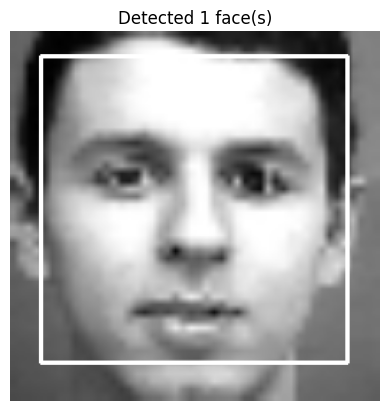

In [44]:
# Test with an example image
test_image = CK_df.loc[152, 'pixels']
detected_image, faces = detect_faces(test_image)

# Display the results
plt.imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"Detected {len(faces)} face(s)")
plt.show()

Face Detection Works!
now we can modify the logic above to start building our tensor flow layers.
We'll modify this so it outputs the cropped facial region, that way only the facial region gets fed into the next layer

In [45]:
class FaceDetectionLayer(tf.keras.layers.Layer):
    def __init__(self, face_cascade_path, target_size=(256, 256), face_size=(96, 96)):
        super(FaceDetectionLayer, self).__init__()
        self.target_size = target_size
        self.face_size = face_size
        self.face_cascade = cv2.CascadeClassifier(face_cascade_path)  # Load Haar Cascade

    def detect_faces(self, image):
        # Detect faces
        if image.dtype != 'uint8':
            image = cv2.convertScaleAbs(image)
        faces = self.face_cascade.detectMultiScale(image, scaleFactor=1.01, minNeighbors=5, minSize=(30, 30))

        # If no faces are detected, return a blank face
        # if len(faces) == 0:
            # return np.zeros((self.face_size[0], self.face_size[1], 3), dtype=np.uint8)
        #pull first detected face
        x, y, w, h = faces[0]
        face_region = image[y:y+h, x:x+w]  # Crop face
        
        # Check number of channels before converting
        if len(face_region.shape) == 2:  # If grayscale
            face_rgb = cv2.cvtColor(face_region, cv2.COLOR_GRAY2RGB)
        else:  # Already RGB
            face_rgb = face_region
        resized_face = cv2.resize(face_rgb, self.face_size, interpolation=cv2.INTER_LINEAR)
        return resized_face

    
    def call(self, inputs):
        def process_single_sample(pixels):
            # Convert convert tensor to numpy arr for processing
            image = pixels.numpy().reshape(self.target_size[0], self.target_size[1], 3)
            cropped_face = self.detect_faces(image)
            return cropped_face
        # Use tf.py_function to integrate OpenCV logic with Tensorflow
        outputs = tf.map_fn(
            lambda x: tf.py_function(func=process_single_sample, inp=[x], Tout=tf.uint8),
            inputs,
            dtype=tf.uint8
        )
        outputs.set_shape([None, 96, 96, 3])
        return outputs / 255
    
    def compute_output_shape(self, input_shape):
        # The output will be a stack of cropped and resized face images, each with shape (64, 64, 3)
        return tf.TensorShape((input_shape[0], self.face_size[0], self.face_size[1], 3))

Next we build the layer we need for Skin Segmentation using a YCbCr color space

In [46]:
class SkinSegmentationLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(SkinSegmentationLayer, self).__init__()

    def call(self, inputs):
        # Convert the input BGR image (64x64x3) to YCbCr format
        ycbcr_image = tf.image.rgb_to_yuv(inputs)
        #print(ycbcr_image.numpy())

        # Extract the Cb and Cr channels from the YCbCr image
        cb = ycbcr_image[..., 1]
        cr = ycbcr_image[..., 2]

        # Define the thresholds for skin segmentation
        min_cb, max_cb = 65/255, 145/255
        min_cr, max_cr = 120/255, 190/255

        # Create a mask by checking if the Cb and Cr values are within the skin range
        skin_mask = tf.logical_and(
            tf.logical_and(cb >= min_cb, cb <= max_cb),
            tf.logical_and(cr >= min_cr, cr <= max_cr)
        )

        # Convert the boolean mask to float (1 for skin, 0 for non-skin)
        skin_mask = tf.cast(skin_mask, tf.float32)
        
        return tf.expand_dims(skin_mask, axis=3) * inputs
    
    def compute_output_shape(self, input_shape):
        return input_shape

In [47]:
class PCALayer(tf.keras.layers.Layer):
    def __init__(self, n_components=50):
        super(PCALayer, self).__init__()
        self.n_components = n_components
        self.pca = PCA(n_components=self.n_components, svd_solver='auto')

    def pca_fit_transform(self, inputs):
        # Convert the tensor inputs to numpy arrays and fit
        inputs_np = inputs.numpy()
        return self.pca.fit_transform(inputs_np)

    def pca_transform(self, inputs):
        # Convert the tensor inputs to numpy arrays and transform
        inputs_np = inputs.numpy()
        return self.pca.transform(inputs_np)

    def call(self, inputs, training=False):
        # Remove the last dimension and flatten
        # inputs = tf.ensure_shape(inputs, (None, 96, 96))
        inputs = tf.reshape(inputs, (tf.shape(inputs)[0], -1))  # Flatten to (batch_size, 64*64)

        # During training, we fit and transform the inputs, only transform otherwise
        if training:
            outputs = tf.py_function(self.pca_fit_transform, [inputs], tf.float32)
        else:
            outputs = tf.py_function(self.pca_transform, [inputs], tf.float32)
        outputs.set_shape([None, self.n_components])
        
        return outputs
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.n_components)

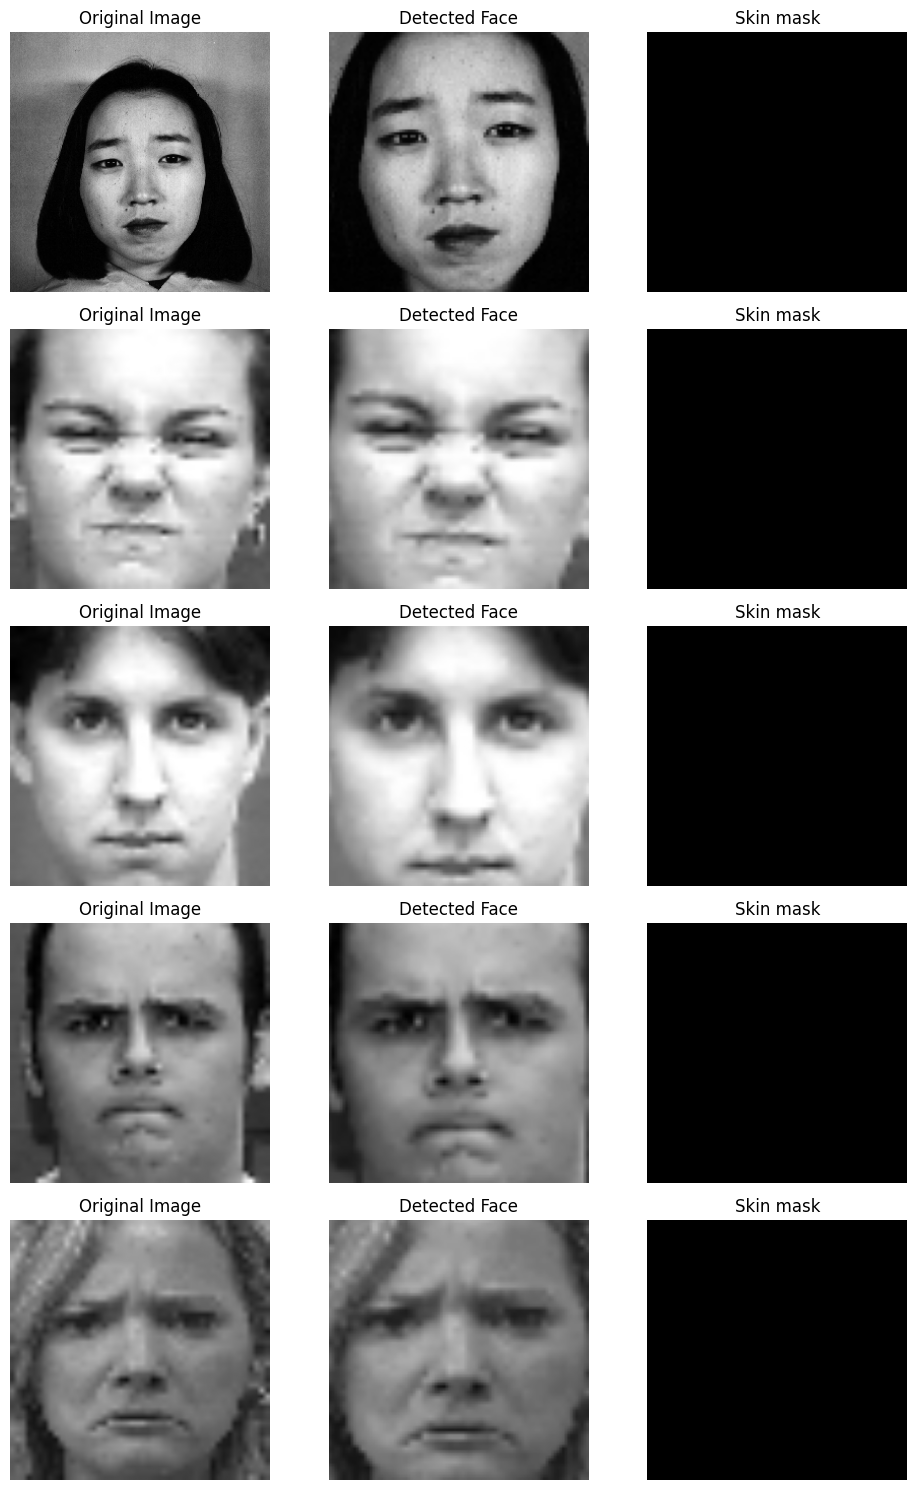

In [56]:
# Sample batch of images from the training dataset
sample_batch = X_train[:5]

# Pass the sample batch through the Layers
face_detection_layer = FaceDetectionLayer(face_cascade_path=cascade_path)
skin_segmentation_layer = SkinSegmentationLayer()
detected_faces = face_detection_layer(sample_batch)
skin_masks = skin_segmentation_layer(detected_faces)

# Visualize the original images and the detected faces

fig, axes = plt.subplots(5, 3, figsize=(10, 15))
for i in range(5):
    axes[i, 0].imshow(sample_batch[i] / 255.0)
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(detected_faces[i])
    axes[i, 1].set_title("Detected Face")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(skin_masks[i])
    axes[i, 2].set_title("Skin mask")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

In [49]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape = (256,256,3)),
    FaceDetectionLayer(face_cascade_path= cascade_path),
    #SkinSegmentationLayer(),
    PCALayer(n_components=30),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax'),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=.001)
sample_input = tf.convert_to_tensor(X_train[:1], dtype=tf.float32)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [50]:
model.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
Instructions for updating:
Use fn_output_signature instead
9/9 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.1827 - loss: 2.3878
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.1749 - loss: 2.2094
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.2236 - loss: 2.0362
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.2534 - loss: 1.9521
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.2513 - loss: 1.9084
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.2386 - loss: 1.9186
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.2764 - loss: 1.8005
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.2312 - loss: 1.8858
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.2561 - loss: 1.8545
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.2359 - loss: 1.8384


In [51]:
#model.pop()

def temp_softmax(z, temp):
    return tf.nn.softmax(z / temp)

def model_predict(x, temp=2):
    return temp_softmax(model.predict(x), temp)

In [52]:
predictions = model.predict(X_test)
# predictions = model_predict(X_test, temp=1)
predicted_classes = tf.argmax(predictions, axis=1)
true_classes = y_test
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(predictions)
print(predicted_classes)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.2535 - loss: 1.7933
[[1.15541883e-01 1.07884534e-01 1.19864009e-01 1.88037217e-01
  1.60488471e-01 2.90093124e-01 1.80908013e-02]
 [1.69682384e-01 1.88874274e-01 1.44710958e-01 1.13156207e-01
  3.24768215e-01 5.85161373e-02 2.91794364e-04]
 [8.33594725e-02 1.88825518e-01 1.53599620e-01 2.16223344e-01
  1.09973677e-01 1.54248118e-01 9.37702656e-02]
 [7.45390728e-02 1.56430766e-01 8.04364085e-02 1.88802004e-01
  3.69498134e-01 1.21750206e-01 8.54336005e-03]
 [4.42873649e-02 3.37649465e-01 2.46892348e-02 4.55137193e-02
  9.38428193e-02 1.37259379e-01 3.16758066e-01]
 [3.10323745e-01 1.54773816e-01 1.13370173e-01 9.18058157e-02
  8.94547850e-02 8.15885216e-02 1.58683166e-01]
 [7.69880041e-02 7.43162930e-02 9.05685872e-02 2.57721066e-01
  6.86368197e-02 2.68324733e-01 1.63444504e-01]
 [6.79187924e-02 1.45258188e-01 7.74048120e-02 1.42046297e-02
  1.73204303e-01 6.32866472e-02 4.58722651e-01]
 [1.03699803

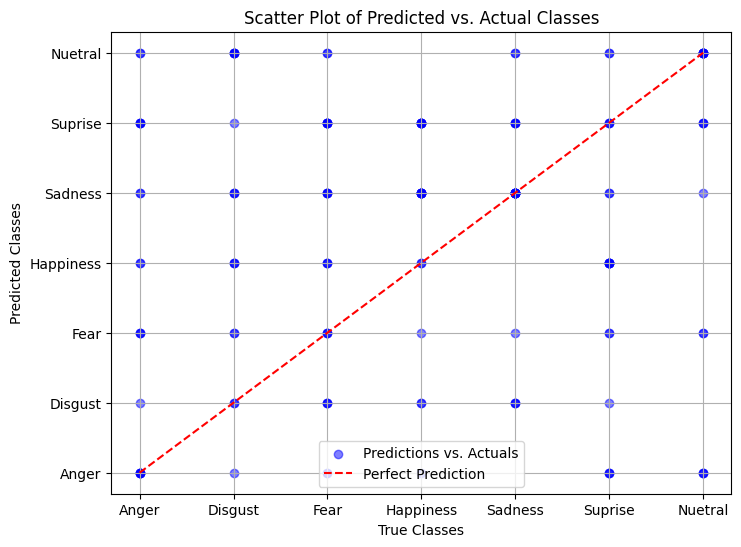

In [53]:
plt.figure(figsize=(8, 6))
plt.scatter(true_classes, predicted_classes, color='blue', alpha=0.5, label='Predictions vs. Actuals')
# Add diagonal line representing perfect predictions
plt.plot([0, 6], [0, 6], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Scatter Plot of Predicted vs. Actual Classes')
plt.xlabel('True Classes')
plt.ylabel('Predicted Classes')
plt.xticks(np.arange(7), ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Suprise', 'Nuetral'])
plt.yticks(np.arange(7), ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Suprise', 'Nuetral'])
plt.legend()
plt.grid(True)
plt.show()

Confusion Matrix:
[[ 5  1  3  2  2  4  2]
 [ 1  2  2  3  3  1  5]
 [ 2  3  3  3  4  6  2]
 [ 1  2  1  2  9  7  0]
 [ 0  3  1  0 12  4  2]
 [ 3  1  2  7  2  3  2]
 [ 3  0  2  0  1  3  8]]


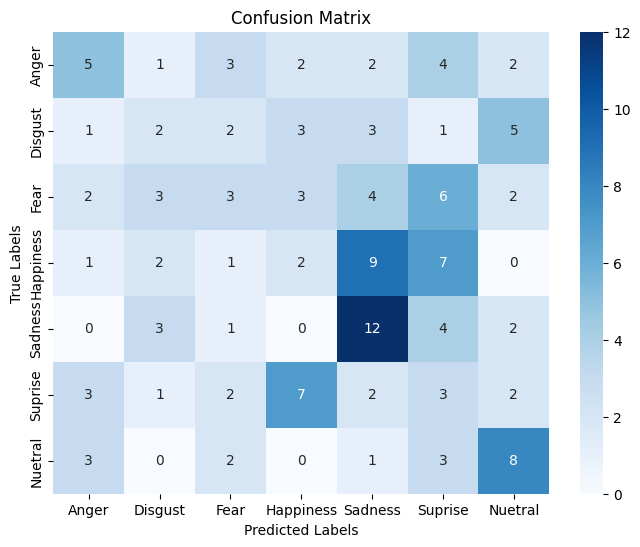

In [54]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Suprise', 'Nuetral'], 
            yticklabels=['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Suprise', 'Nuetral'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [55]:
report = classification_report(true_classes, predicted_classes)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.26      0.29        19
           1       0.17      0.12      0.14        17
           2       0.21      0.13      0.16        23
           3       0.12      0.09      0.10        22
           4       0.36      0.55      0.44        22
           5       0.11      0.15      0.12        20
           6       0.38      0.47      0.42        17

    accuracy                           0.25       140
   macro avg       0.24      0.25      0.24       140
weighted avg       0.24      0.25      0.24       140

